# Project - Neural Machine Translation

In [9]:
# Download the French-English translation dataset in zip format.
!curl -o fra-eng.zip http://www.manythings.org/anki/fra-eng.zip

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7575k  100 7575k    0     0  4829k      0  0:00:01  0:00:01 --:--:-- 4828k


In [10]:
# Import necessary libraries and modules.
import zipfile
import string
from unidecode import unidecode
import unicodedata
import re
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, RepeatVector, Dense, TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras import optimizers
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
# Extract the contents of the downloaded zip file to a 'data' folder.
with zipfile.ZipFile("fra-eng.zip", "r") as zip_ref:
    zip_ref.extractall("data")

In [12]:
# Define a function to clean the text data.
def clean_text(text):
    # Decode the text from unicode to plain text.
    word = unidecode(text)
    # Remove special characters and numbers, keep only alphabets.
    word = re.sub('[^a-zA-z]', ' ', word)
    # Remove extra spaces, strip leading/trailing spaces.
    word = word.strip()
    # Convert the text to lowercase.
    word = word.lower()
    # Normalize text to a standard form.
    word = "".join(w for w in unicodedata.normalize('NFKD', word))
    return word

In [13]:
# Clean a sample sentence as an example.
clean_text('prenez vos jambes à vos cous')

'prenez vos jambes a vos cous'

In [14]:
# Read the cleaned data from the 'fra.txt' file and split it into lines.
with open("data/fra.txt", "r", encoding="utf-8") as file:
    lines = file.read().strip().split("\n")

# Split each line into pairs of French and English sentences, limit to 100,000 pairs.
pairs = [line.split("\t") for line in lines[:100000]]

# Clean the text in each pair and store them in a NumPy array
cleaned_pairs = np.array([[clean_text(pair[0]), clean_text(pair[1])] for pair in pairs])

# Shuffle the cleaned pairs randomly.
random.shuffle(cleaned_pairs)

In [15]:
# Display the first 20 cleaned pairs.
cleaned_pairs[:20]

array([['go', 'va'],
       ['go', 'va'],
       ['go', 'marche'],
       ['go', 'va'],
       ['go', 'bouge'],
       ['go', 'marche'],
       ['go', 'bouge'],
       ['go', 'en route'],
       ['go', 'va'],
       ['go', 'bouge'],
       ['run', 'prenez vos jambes a vos cous'],
       ['run', 'cours'],
       ['go', 'bouge'],
       ['run', 'courez'],
       ['run', 'fuyons'],
       ['run', 'cours'],
       ['run', 'fuyons'],
       ['run', 'cours'],
       ['run', 'prenez vos jambes a vos cous'],
       ['go', 'en route']], dtype='<U71')

In [16]:
# Separate the French and English sentences into two arrays.
target_eng = cleaned_pairs[:,0]
input_fre = cleaned_pairs[:,1]

# Check the shapes of the arrays.
target_eng.shape, input_fre.shape

((100000,), (100000,))

In [17]:
# Split the data into training and testing sets.
x_train, x_test, y_train, y_test = train_test_split(input_fre, target_eng, test_size = 0.20, random_state = 42)

In [18]:
# Define a function for tokenization.
def tokenization(text_data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text_data)
    integer_sequence = tokenizer.texts_to_sequences(text_data)
    vocab = tokenizer.word_index
    vocab_size = len(vocab) + 1
    max_seq_len = max(len(seq) for seq in integer_sequence)
    return tokenizer, vocab, vocab_size, max_seq_len

In [19]:
# Define a function to convert text to integer sequences with padding.
def integer_seq_with_padding(tokenizer, text, max_seq_len):
    integer_sequence = tokenizer.texts_to_sequences(text)
    sequence_padded = pad_sequences(integer_sequence, maxlen = max_seq_len, padding = 'post')
    return sequence_padded

In [20]:
# Tokenize and get vocabulary information for French and English.
fre_tokenizer ,fre_vocab, fre_vocab_size, max_fre_seq_len = tokenization(input_fre)
eng_tokenizer ,eng_vocab, eng_vocab_size, max_eng_seq_len = tokenization(target_eng)

In [21]:
# Convert training and testing data to padded integer sequences.
x_train_padded = integer_seq_with_padding(fre_tokenizer ,x_train, max_fre_seq_len)
y_train_padded = integer_seq_with_padding(eng_tokenizer ,y_train, max_eng_seq_len)
x_test_padded = integer_seq_with_padding(fre_tokenizer ,x_test, max_fre_seq_len)
y_test_padded = integer_seq_with_padding(eng_tokenizer ,y_test, max_eng_seq_len)

In [22]:
# Define the Sequential model using Keras.
model = Sequential([Embedding(input_dim = fre_vocab_size + 1, output_dim=256, input_length = max_fre_seq_len),
                    LSTM(256, dropout = 0.3),
                    RepeatVector(max_eng_seq_len),
                    LSTM(256, return_sequences = True, dropout = 0.3),
                    TimeDistributed(Dense(eng_vocab_size + 1, activation="softmax"))])
# Compile the model.
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [23]:
# Define early stopping callback.
es = EarlyStopping(monitor = "val_accuracy",patience = 5, min_delta = 0.01)

In [24]:
# Train the model.
history = model.fit(x_train_padded, y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1],1),
                    epochs = 50,
                    batch_size = 64,
                    validation_data = (x_test_padded, y_test_padded.reshape(y_test_padded.shape[0], y_test_padded.shape[1],1)),
                    callbacks = [es])

Epoch 1/50
1250/1250 [==============================] - 32s 20ms/step - loss: 2.9245 - accuracy: 0.5703 - val_loss: 2.7559 - val_accuracy: 0.5737
Epoch 2/50
1250/1250 [==============================] - 15s 12ms/step - loss: 2.7291 - accuracy: 0.5757 - val_loss: 2.7176 - val_accuracy: 0.5768
Epoch 3/50
1250/1250 [==============================] - 15s 12ms/step - loss: 2.7065 - accuracy: 0.5757 - val_loss: 2.7086 - val_accuracy: 0.5743
Epoch 4/50
1250/1250 [==============================] - 15s 12ms/step - loss: 2.6922 - accuracy: 0.5759 - val_loss: 2.7028 - val_accuracy: 0.5769
Epoch 5/50
1250/1250 [==============================] - 15s 12ms/step - loss: 2.6880 - accuracy: 0.5758 - val_loss: 2.6991 - val_accuracy: 0.5769
Epoch 6/50
1250/1250 [==============================] - 15s 12ms/step - loss: 2.6042 - accuracy: 0.5865 - val_loss: 2.2600 - val_accuracy: 0.6370
Epoch 7/50
1250/1250 [==============================] - 15s 12ms/step - loss: 1.9258 - accuracy: 0.6787 - val_loss: 1.6835 -

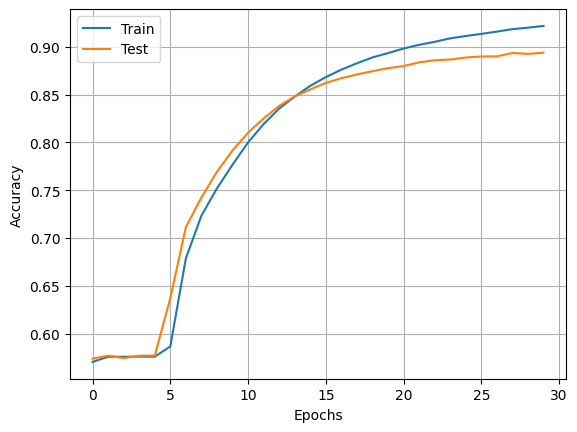

In [25]:
# Plot training and testing accuracy.
train_data_acc = history.history['accuracy']
test_data_acc = history.history['val_accuracy']
plt.plot(train_data_acc)
plt.plot(test_data_acc)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

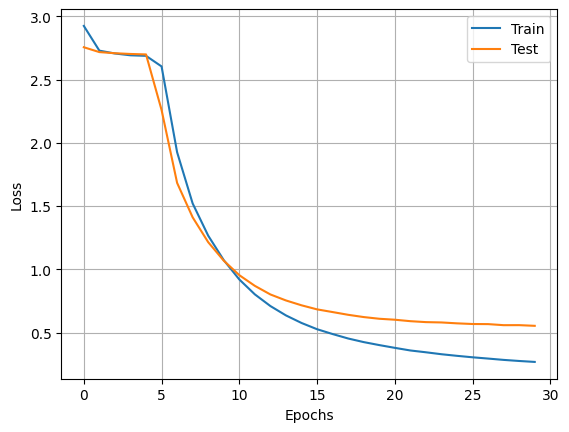

In [26]:
# Plot training and testing loss.
train_data_loss = history.history['loss']
test_data_loss = history.history['val_loss']
plt.plot(train_data_loss)
plt.plot(test_data_loss)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

In [27]:
# Make predictions using the model.
predicted = model.predict(x_test_padded)

625/625 [==============================] - 2s 2ms/step


In [28]:
preds = []
for seq in predicted:
    temp = []
    for j in seq:
        temp.append(np.argmax(j))
    # Remove padding (0) from the predictions.
    temp = [w for w in temp if w != 0]
    preds.append(temp)
preds[:5]

[[13, 7, 13, 703, 205],
 [1, 47, 2, 14, 19, 17],
 [17, 7, 363],
 [19, 2, 45, 31, 1, 295],
 [144, 3, 2363]]

In [29]:
# Convert integer sequences back to text using the English tokenizer.
predict_text = eng_tokenizer.sequences_to_texts(preds)
predict_text[:5]

['that s that fake idea',
 'i need you to do this',
 'this s weird',
 'do you know what i mean',
 'make it larger']

In [30]:
# Create a DataFrame to compare actual and predicted translations.
df = pd.DataFrame({'Text': y_test, 'Predicted':predict_text})
df.head(10)

,Text,Predicted
0,this is my brainchild,that s that fake idea
1,i need you to do that,i need you to do this
2,this is bizarre,this s weird
3,do you see my point,do you know what i mean
4,make it larger,make it larger
5,where were the police,where was the others
6,get lost,get away
7,we count on you,we count on you
8,hold the handrail,hold the handrail
9,i disobeyed you,i disobeyed you


In [31]:
# Calculate the average BLEU score for the translations.
Sum = 0
for i in range(len(df)):
    reference = [df['Text'][i].split()]
    candidate = df['Predicted'][i].split()
    score = sentence_bleu(reference, candidate, weights = (1.0, 0, 0, 0))
    Sum += score
print("The average Bleu Score is {:.2f} %".format(Sum*100/len(df)))

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


The average Bleu Score is 80.98 %


#### Using Pretrained Model
I used Hugging Face Transformers library to import below model

In [32]:
# Import MarianMTModel and MarianTokenizer from transformers library.
from transformers import MarianMTModel, MarianTokenizer
import torch

# Define the model name for translation.
model_name = "Helsinki-NLP/opus-mt-fr-en"

# Create a tokenizer and model for translation.
tokenizer = MarianTokenizer.from_pretrained(model_name)
# Define input text for translation.
model = MarianMTModel.from_pretrained(model_name)

/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [33]:
# Translate each sentence in the array
english_translations = []

# Only used 10 sentences to show the performance
for french_sentence in x_test[:10]:
    input_ids = tokenizer.encode(french_sentence, return_tensors="pt")
    with torch.no_grad():
        output = model.generate(input_ids, max_length=30, num_beams=4, early_stopping=True)
    translated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    english_translations.append(translated_text)

In [34]:
pd.DataFrame({"X_test":x_test[:10], "Translated": english_translations, "Y_test": y_test[:10]})

,X_test,Translated,Y_test
0,c est une idee qui vient de moi,It's an idea from me.,this is my brainchild
1,j ai besoin que tu fasses ca,I need you to do that.,i need you to do that
2,c est etrange,c is strange,this is bizarre
3,tu comprends ce que je veux dire,You understand what I mean.,do you see my point
4,agrandissez le,enlarge it,make it larger
5,ou se trouvait la police,where the police were,where were the police
6,decampe,campground,get lost
7,nous comptons sur toi,we count on you,we count on you
8,tiens la rampe,hold the ramp,hold the handrail
9,je vous ai desobei,I have desobeyed you.,i disobeyed you
